### Imports

In [1]:
import xarray as xr
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

### Functions

In [2]:
def detrend(da):
    da.values[np.isnan(da.values)] = 0.0
    return signal.detrend(da,axis=0)  

### Read Data, Select times, Reverse lats

In [3]:
fname = '/scratch/kpegion/sst.mon.mean.COBE.nc'
ds = xr.open_dataset(fname,decode_times=True).sel(time=slice('1880-01','2017-12'))
ds=ds.reindex(lat=list(reversed(ds['lat'])))
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1656)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2017-12-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            created 12/2013 from data provided by JRA
    history:          Created 12/2012 from data obtained from JRA by ESRL/PSD
    platform:         Analyses
    citation:         Hirahara, S., Ishii, M., and Y. Fukuda,2014: Centennial...
    institution:      NOAA ESRL/PSD
    Conventions:      CF-1.2
    dataset_title:    COBE-SST2 Sea Surface Temperature and Ice
    original_source:  https://climate.mri-jma.go.jp/pub/ocean/cobe-sst2/
    References:       http://www.psl.noaa.gov/data/gridded/cobe2.html

### Make anomalies

In [4]:
ds_climo = ds.sel(time=slice('1980-01','2009-12')).groupby('time.month').mean(dim='time')
ds_anom = ds.groupby('time.month') - ds_climo

### Detrend and put back into `xr.Dataset`

In [5]:
anoms_detrend = detrend(ds_anom['sst'])

ds_tmp=xr.DataArray(anoms_detrend,
                    coords={'time':ds['time'],
                            'lat':ds['lat'],
                            'lon': ds['lon']},
                    dims=['time','lat','lon'])        
ds_anom_detrend=ds_tmp.to_dataset(name='sst')
ds_anom_detrend

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1656)
Coordinates:
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2017-12-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    sst      (time, lat, lon) float32 0.0 0.0 0.0 ... 0.02829 0.02819 0.02862

### Make Nino3.4

In [6]:
ds_nino = ds_anom_detrend.sel(lat=slice(-5,5),lon=slice(360-170,360-120)).mean(dim=['lat','lon'])
ds_nino

<xarray.Dataset>
Dimensions:  (time: 1656)
Coordinates:
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2017-12-01
Data variables:
    sst      (time) float32 -1.808 -0.3871 -0.3249 ... -0.4857 -0.711 -1.056

### Split Train and Test

In [7]:
# Get the years for the Predictors (aka Features)
sst_anom_train=ds_anom_detrend.sel(time=slice('1880-01','1990-12'))
sst_anom_test=ds_anom_detrend.sel(time=slice('1990-01','2017-12'))

# Extract only El Nino and La Nina Events
sst_anom_train=sst_anom_train['sst'][0:len(sst_anom_train['time']),:,:].where(np.abs(ds_nino['sst'])>0.5).dropna(dim='time',how='all')
sst_anom_test=sst_anom_test['sst'][0:len(sst_anom_train['time']),:,:].where(np.abs(ds_nino['sst'])>0.5).dropna(dim='time',how='all')


# Get the years for the Predictand
nino_train=ds_nino.sel(time=slice('1880-01','1990-12'))
nino_test=ds_nino.sel(time=slice('1990-01','2017-12'))

# Select only El Nino and La nina Events
nino_train=nino_train['sst'].where(np.abs(ds_nino['sst'])>0.5).dropna(dim='time',how='all')
nino_test=nino_test['sst'].where(np.abs(ds_nino['sst'])>0.5).dropna(dim='time',how='all')

### Get dimensions for use later

In [8]:
nx=len(ds['lon'])
ny=len(ds['lat'])
nt=len(ds['time'])
print(nx,ny,nt)

360 180 1656


### Turn into categorization problem with 1's and 0's for warm and cold events

In [9]:
# Predictors ( aka Features ): Training on first nt_train months 
X_train=sst_anom_train.values

# Create output vector based as a Categorical Predictand El Nino = [True,False] and La Nina = [False,True]
l_warm_train = ( nino_train > 0.5 )
l_cold_train = ( nino_train < -0.5 )
y_train = np.array([l_warm_train,l_cold_train]).T

# Get dimensions of training data
nt_train,junk=y_train.shape
y_train.shape

(668, 2)

### Set Y for prediction problem

In [10]:
#nmon=1
nmon=12
y_train=y_train[nmon:nt_train,:]
X_train=X_train[0:nt_train-nmon,:,:]
nt_train=nt_train-nmon

In [11]:
print(X_train.shape,y_train.shape, nt_train)

(656, 180, 360) (656, 2) 656


In [12]:
print("El Nino TRAIN: ",l_warm_train[l_warm_train==True].count().values)
print("La Nina TRAIN: ",l_cold_train[l_cold_train==True].count().values)

El Nino TRAIN:  318
La Nina TRAIN:  350


### Make a keras model

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras import initializers
from keras import optimizers

Using TensorFlow backend.


In [14]:
model = Sequential()

model.add(Dense(8, input_dim=nx*ny,activation='relu',
                kernel_initializer='he_normal',
                kernel_regularizer=regularizers.l2(25),
                bias_initializer='he_normal'))

model.add(Dense(8, activation='relu',
                kernel_initializer='he_normal',
                bias_initializer='he_normal',
                kernel_regularizer=regularizers.l2(0.01)))

model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', 
              metrics=['accuracy'],
              optimizer=optimizers.SGD(lr=0.001,nesterov=True,momentum=0.9))







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Train the NN

In [15]:
XX = X_train.reshape(nt_train,nx*ny)
model.fit(XX, y_train, epochs=100, batch_size=60)

Epoch 1/100
656/656 [==============================] - 0s 662us/step - loss: 122.0530 - acc: 0.5198
Epoch 2/100
656/656 [==============================] - 0s 237us/step - loss: 27.0697 - acc: 0.5305
Epoch 3/100
656/656 [==============================] - 0s 231us/step - loss: 4.1953 - acc: 0.5381
Epoch 4/100
656/656 [==============================] - 0s 227us/step - loss: 1.4280 - acc: 0.5213
Epoch 5/100
656/656 [==============================] - 0s 237us/step - loss: 1.1481 - acc: 0.5335
Epoch 6/100
656/656 [==============================] - 0s 251us/step - loss: 1.0256 - acc: 0.5442
Epoch 7/100
656/656 [==============================] - 0s 232us/step - loss: 0.9624 - acc: 0.5732
Epoch 8/100
656/656 [==============================] - 0s 232us/step - loss: 0.9406 - acc: 0.5655
Epoch 9/100
656/656 [==============================] - 0s 237us/step - loss: 0.9184 - acc: 0.5595
Epoch 10/100
656/656 [==============================] - 0s 230us/step - loss: 0.9002 - acc: 0.5915
Epoch 11/100
656

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 518408    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total params: 518,498
Trainable params: 518,498
Non-trainable params: 0
_________________________________________________________________


In [17]:
# evaluate the keras model
_, accuracy = model.evaluate(XX, y_train)
print('Training Accuracy: %.2f' % (accuracy*100))

656/656 [==============================] - 0s 178us/step
Training Accuracy: 66.01


### Test the Model Accuracy using Test Data
Need to setup for N-month lead

In [18]:
# Predictors ( aka Features )
#X_test=sst_anom_test.values

# Select El Nino and La Nina (Categorical Predictand)
#l_warm_test = ( nino_test > 0.5 )
#l_cold_test = ( nino_test < -0.5 )
#y_test = np.array([l_warm_test,l_cold_test]).T

#nt_test,junk=y_test.shape

#y_test.shape

In [19]:
#XX_test = X_test.reshape(nt_test,nx*ny)
#XX_test[np.isnan(XX_test)] = 0.0

In [20]:
#_, test_accuracy = model.evaluate(XX_test, y_test)
#print('Testing Accuracy: %.2f' % (test_accuracy*100))

### Apply `iNNvestigate` using all El Nino and La Nina Cases as Input

In [21]:
import innvestigate
import innvestigate.utils

In [22]:
# Predictors ( aka Features ): Training on first nt_train months 
X=ds_anom_detrend['sst'][0:nt,:,:].where(np.abs(ds_nino['sst'])>0.5).dropna(dim='time',how='all').values
nt_new,ny,nx=X.shape
X=X.reshape(nt_new,nx*ny)
print(nt_new)

# Select El Nino and La Nina (Categorical Predictand)
y=ds_nino['sst'].where(np.abs(ds_nino['sst'])>0.5).dropna(dim='time',how='all')
l_warm = ( y > 0.5 )
l_cold = ( y < -0.5 )
y = np.array([l_warm,l_cold]).T

y.shape

845


(845, 2)

In [23]:
print("El Nino ALL: ",l_warm[l_warm==True].count().values)
print("La Nina ALL: ",l_cold[l_cold==True].count().values)

El Nino ALL:  410
La Nina ALL:  435


In [24]:
# Strip softmax layer
model = innvestigate.utils.model_wo_softmax(model)

# Create analyzer
analyzer = innvestigate.create_analyzer("deep_taylor", model)

# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(X)

In [25]:
a.shape

(845, 64800)

### Get El Nino Cases, Reshape to `time,lat,lon`

In [26]:
# Get El Nino Cases
a_warm=a[l_warm==True,:]

# Reshape to time,lat,lon
tmp=a_warm.shape
a=a_warm.reshape((tmp[0],ny,nx))

# Find times corresponding to El Nino
ds_time=ds_anom_detrend['sst'][0:nt,:,:].where(np.abs(ds_nino['sst'])>0.5).dropna(dim='time',how='all')['time'][l_warm==True]

### Make `xarray.Dataset`

In [27]:
ds_tmp=xr.DataArray(a,
                    coords={'time':ds_time,
                            'lat':ds['lat'].values,
                            'lon': ds['lon'].values},
                    dims=['time','lat','lon'])        
ds_lrp=ds_tmp.to_dataset(name='warm')

### Normalize by max value in grid for each input

In [28]:
ds_lrp=ds_lrp/ds_lrp.max(dim=['lat','lon'])
ds_lrp

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 410)
Coordinates:
  * time     (time) datetime64[ns] 1880-12-01 1881-01-01 ... 2016-05-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    warm     (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... -0.0 -0.0 -0.0 -0.0

### Plot Composite Relevance for N-month prediction

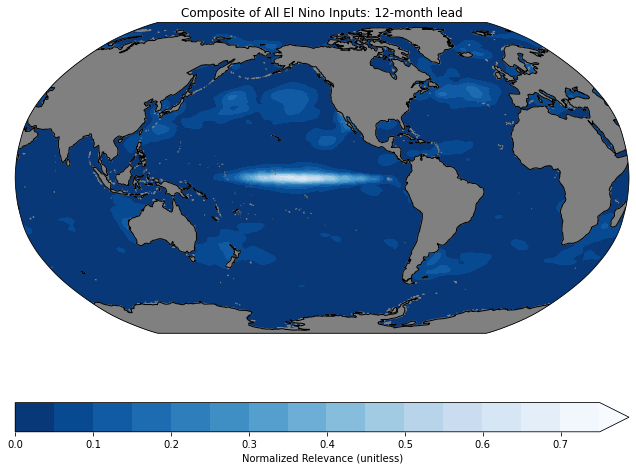

In [31]:
from cartopy.util import add_cyclic_point
clevs=np.arange(0.0,0.8,.05)

fig = plt.figure(figsize=(11,8.5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=230))
data, lons = add_cyclic_point(ds_lrp['warm'].mean(dim='time'), coord=ds['lon'])
cs=ax.contourf(lons, ds['lat'], data,clevs,
               transform = ccrs.PlateCarree(),cmap='Blues_r',
               extend='max')
ax.add_feature(cfeature.NaturalEarthFeature('physical','land','50m', 
                                            edgecolor='gray', facecolor='gray'))
ax.coastlines()
ax.set_title('Composite of All El Nino Inputs: '+str(nmon)+'-month lead')
plt.colorbar(cs,orientation='horizontal',label='Normalized Relevance (unitless)')
plt.savefig('../figs/lrp_comp_elnino_COBE_lead'+str(nmon)+'months.png')